In [1]:
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [2]:
df = pd.read_csv('psl.csv')
df.head()

,date,venue,bat_team,bowl_team,ball,overs,runs,runs_last_5,wickets_last_5,wickets,total
0,2016-02-04,Dubai International Cricket Stadium,Islamabad United,Quetta Gladiators,1,0.1,0,0,0,0,128
1,2016-02-04,Dubai International Cricket Stadium,Islamabad United,Quetta Gladiators,2,0.2,0,0,0,0,128
2,2016-02-04,Dubai International Cricket Stadium,Islamabad United,Quetta Gladiators,3,0.3,0,0,0,0,128
3,2016-02-04,Dubai International Cricket Stadium,Islamabad United,Quetta Gladiators,4,0.4,0,0,0,0,128
4,2016-02-04,Dubai International Cricket Stadium,Islamabad United,Quetta Gladiators,5,0.5,0,0,0,0,128


In [3]:
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

df = df[df['ball']<=6]
df = df[df['overs']>=5.0]
cols_to_drop = ['ball']
df.drop(cols_to_drop,axis=1,inplace=True)



def f(x):
    if x=='Dubai International Cricket Stadium':
        return 'Dubai International Cricket Stadium, Dubai'
    elif x=='Gaddafi Stadium':
        return 'Gaddafi Stadium, Lahore'
    elif x=='Multan Cricket Stadium':
        return 'Multan Cricket Stadium, Multan'
    elif x=='National Stadium':
        return 'National Stadium, Karachi'
    elif x=='Rawalpindi Cricket Stadium':
        return 'Rawalpindi Cricket Stadium, Rawalpindi'
    elif x=='Sharjah Cricket Stadium':
        return 'Sharjah Cricket Stadium, Sharjah'
    elif x=='Sheikh Zayed Stadium':
        return 'Sheikh Zayed Stadium, Abu Dhabi'
    else:
        return x
    
df['venue'] = df['venue'].apply(f)

df_new = pd.get_dummies(data=df,columns=['venue','bat_team','bowl_team'])


df_new = df_new[['date', 'venue_Dubai International Cricket Stadium, Dubai',
'venue_Gaddafi Stadium, Lahore',
'venue_Multan Cricket Stadium, Multan',
'venue_National Stadium, Karachi',
'venue_Rawalpindi Cricket Stadium, Rawalpindi',
'venue_Sharjah Cricket Stadium, Sharjah',
'venue_Sheikh Zayed Stadium, Abu Dhabi',
'bat_team_Islamabad United',
'bat_team_Karachi Kings',
'bat_team_Lahore Qalandars',
'bat_team_Multan Sultans',
'bat_team_Peshawar Zalmi',
'bat_team_Quetta Gladiators',
'bowl_team_Islamabad United',
'bowl_team_Karachi Kings',
'bowl_team_Lahore Qalandars',
'bowl_team_Multan Sultans',
'bowl_team_Peshawar Zalmi',
'bowl_team_Quetta Gladiators', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5',
       'total']]


df_new.reset_index(inplace=True)
df_new.drop('index',inplace=True,axis=1)

In [4]:
scaler = StandardScaler()
scaled_cols = scaler.fit_transform(df_new[['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5']])
pickle.dump(scaler, open('scaler.pkl','wb'))

scaled_cols = pd.DataFrame(scaled_cols,columns=['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'])
df_new.drop(['runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5'],axis=1,inplace=True)
df_new = pd.concat([df_new,scaled_cols],axis=1)


X_train = df_new.drop('total',axis=1)[df_new['date'].dt.year<=2018]
X_test = df_new.drop('total',axis=1)[df_new['date'].dt.year>=2019]

X_train.drop('date',inplace=True,axis=1)
X_test.drop('date',inplace=True,axis=1)


y_train = df_new[df_new['date'].dt.year<=2018]['total'].values
y_test = df_new[df_new['date'].dt.year>=2019]['total'].values

In [5]:
ridge = Ridge()
parameters={'alpha':[1e-15,1e-10, 1e-08, 0.001, 0.01, 5, 10, 20, 30, 35, 40]}
ridge_regressor = GridSearchCV(ridge,parameters,cv=10,scoring='neg_mean_squared_error')
ridge_regressor.fit(X_train,y_train)

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.04207e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 5, 10, 20,
                                   30, 35, 40]},
             scoring='neg_mean_squared_error')

In [6]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

prediction_r = ridge_regressor.predict(X_test)
print('MAE:', mean_absolute_error(y_test, prediction_r))
print('MSE:', mean_squared_error(y_test, prediction_r))
print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction_r)))
print(f'r2 score of ridge : {r2_score(y_test,prediction_r)}')

{'alpha': 40}
-394.81981052079794
MAE: 16.649024354192065
MSE: 455.8945557164235
RMSE: 21.35168742082048
r2 score of ridge : 0.5102329923218212


C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

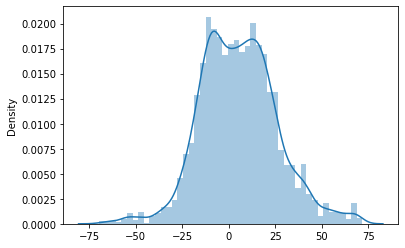

In [7]:
sns.distplot(y_test-prediction_r)

In [8]:
joblib.dump(ridge_regressor,'pslmodel_ridge.sav')

['pslmodel_ridge.sav']